# **GENERATIVE ADVERSARIAL NETWORK - GAN**

Uma generative adversarial network tem como principal característica a capacidade de criar por conta própria.

- Aplicações:
  - Criar textos.
  - Criar imagens.
  - Aumentar a resolução de imagens.
  - Converter texto para imagem (descreve a imagem e ele gera).

A construção de uma GAN consiste em duas partes, o **Gerador** e o **Descriminador**.

Cada uma dessas partes é constituída por uma rede neural. Elas trabalham em conjunto sendo que o gerador gera uma saída com base numa entrada ruidosa (conjunto de valores aleatórios) e a apresenta ao descriminador, que irá analisá-la e definir se ela faz ou não sentido, para determinar isso o descriminador precisa previamente saber reconhecer aquele tipo de dado (imagens de gatos, textos de um dado autor, etc), e caso a saída do gerador não faça sentido, o descriminador retorna a informação para o gerador que por sua vez irá melhorar sua capacidade de criação e gerará uma nova saída. Esse processo se repete até que tenhamos uma saída que seja satisfatória para o descriminador.

![](https://cdn-images-1.medium.com/max/1600/0*2Smzp-1MDx2TTwU6.png)

Fonte: https://medium.freecodecamp.org/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394

---
- Links para aprender mais:
  - [Generative Adversarial Networks - Demystified! - Ibtesam Ahmed](https://www.kaggle.com/ibtesama/generative-adversarial-networks-demystified)
  - [Generative Adversarial Networks for beginners - Jon BrunerAdit Deshpande](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners)
  - [Generating Pokemon with a Generative Adversarial Network - Siraj Raval](https://www.youtube.com/watch?v=yz6dNf7X7SA)
  - [Generative Adversarial Networks - Siraj Raval](https://www.youtube.com/watch?v=0VPQHbMvGzg)
  - [Introdução a redes adversariais generativas - Jones Granatyr](https://www.youtube.com/watch?v=KC1kqBTzO50&feature=youtu.be)
  - [Up-sampling with Transposed Convolution - Naoki Shibuya](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
  - [UpSampling - Wikipedia](https://en.wikipedia.org/wiki/Upsampling)
---

> Um ponto importante a se observar é que as GANs normalmente não possuem os valores de perda decrescendo uniformemente, eles são bem oscilantes, o que dificulta muito a criação de uma rede que funcione bem pois assim é complicado definir o quando parar de treinar a rede mediante esse valor, visto que ele é muito oscilante (ao final desse kernel tem um gráfico com os valores das perdas plotados conforme as épocas de execução, ali você poderá entender bem o que estou falando). Para resolver esse problema existe a Wasserstein GAN, que visa melhorar a função de perdas (loss function), porém para esse kernel não a utilizarei, pois aqui tenho como objetivo passar o básico (muito básico) de uma GAN, então vamos por partes que uma hora chegamos lá, mas caso queira ver algo sobre o assunto pode procurar no google que tem bastante material, e se quiser [aqui](https://arxiv.org/abs/1701.07875) tem o link para um artigo sobre o assunto, mas futuramente pretendo criar um kernel nos moldes desse aqui explicando a Wasserstein GAN.

# **IMPLEMENTAÇÃO**
No exemplo a seguir farei a implementação de uma DCGAN, que seria uma Deep Convolutional Generative Adversarial Networks (veja mais sobre CNNs [aqui](https://www.kaggle.com/lucasfdutra/convolutional-neural-network-pt-br?scriptVersionId=10602596)), que basicamente é uma GAN implementada com redes convolucionais. A escolha por uma DCGAN vem do fato de que o objetivo desse exemplo é criar imagens, mais especificamente os dígitos manuscritos da base MNIST (que já vem em conjunto com a biblioteca keras), e por se tratar de imagens a melhor escolha é uma rede convolucional.

> OBS.: O treinamento para uma GAN ficar realmente boa normalmente possui centenas de milhares de épocas, por isso os resultados obtidos aqui não serão dos melhores, pois não deixarei que essa rede tenha tantas épocas assim, afinal demoraria muito tempo para efetuar tantas épocas de treinamento (provavelmente dias).

## IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

Para trabalhar com esse exemplo utilizaremos o tensorflow com o keras sendo sua High level API.

Para ter um melhor entendimento de todos os comando utilizados consulte as documentações do [tensorflow](https://www.tensorflow.org/api_docs/python) e [keras](https://keras.io/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## IMPORTANDO DATASET
O dataset utilizado será o mnist

In [2]:
(x_train, y_train),(_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## NORMALIZANDO OS DADOS DE ENTRADA

In [3]:
x_train = x_train/255

## VERIFICANDO O SHAPE

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

## RESHAPE X_TRAIN
x_train precisa ficar do formato (nº de amostras, x, y, canais)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

## CONSTRUINDO O GERADOR
O gerador é uma rede deconvolucional, ou seja, todo o processo de criação de uma rede convolucional deve ser invertido, sendo que na entrada tem-se a inserção de ruído em formato de vetor e que é passado para um formato de matriz, para se enquadrar como imagem, essa imagem será ampliada até chegar na dimensão desejada.
> As dimensões (x, y, z) das imagens (z é o número de canais - RGB) que saem do gerador devem ser iguais as dimensões das imagens do banco de dados que serão nossas imagens de referência. Nesse caso elas possuem as seguintes dimensões (28, 28, 1).

### **Sobre o modelo do gerador**
- A função de ativação das camadas intermediárias deve ser a função **relu** ou **LeakyRelu**.
- A função de ativação da camada de saída deve ser a função **tangente hiperbólica**.
- Entre todas as camadas deve existir um layer de **Batch Normalization** exceto na entrada do modelo.
- O otimizador deve ser o **Adam Optimizer**.

### **Definindo a dimensão do ruído de entrada**

In [7]:
dimensao_ruido = 200

### **Agora sim pode-se construir o modelo**
O modelo de uma rede convolucional é um modelo sequencial, logo o modelo de uma rede deconvolucional também será.

In [8]:
gerador = tf.keras.models.Sequential()

O primeiro bloco terá  duas camadas, uma densa que é responsável pelos neurônios da rede e uma outra camada que tem por função colocar a entrada no formato de imagem.
Inicialmente teremos uma imagem ruidosa com dimensão 7x7 e 128 canais.
> A dimensão (x, y) irá aumentar com os layers e a quantidade de canais irá reduzir.

In [9]:
gerador.add(tf.keras.layers.Dense(7*7*128, activation='relu', input_dim = dimensao_ruido))
gerador.add(tf.keras.layers.Reshape((7,7,128)))

Agora teremos mais dois blocos que irão seguir a mesma estrutura:
- UpSampling: Aumentará em duas vezes o x e y.
- Convolução: `padding = 'same'`.
- Normalização: Momentum = 0.8.
- Ativação: `relu` nas camadas intermediarias e `tanh` na saída.

> O importante é que a cada bloco a dimensão da imagem seja ampliada.

Para a saída, teremos um layer de convolução que contará com uma redução do número de canais para um.

> - Up-Sampling:
    - Up-Sampling é quando se efetua o processo contrário do max-pooling. Ou seja, tem o objetivo de aumentar a imagem que está sendo inserida na rede.
> - Padding:
  - Same: Adiciona zeros na borda da imagem para que o processo de convolução não reduza a dimensão da imagem.
  - Valid: Não adiciona zeros na borda da imagem, então ocorre uma leve redução da dimensão da mesma.

In [10]:
# 1º Bloco
gerador.add(tf.keras.layers.UpSampling2D(size=(2,2))) # shape = (14,14,128)
gerador.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'))
gerador.add(tf.keras.layers.BatchNormalization(momentum=0.8))
gerador.add(tf.keras.layers.Activation('relu')) # shape = (14,14,64)

# 2º Bloco
gerador.add(tf.keras.layers.UpSampling2D(size=(2,2))) # shape = (28,28,64)
gerador.add(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same'))
gerador.add(tf.keras.layers.BatchNormalization(momentum=0.8))
gerador.add(tf.keras.layers.Activation('relu')) # shape = (28,28,3)

# Saída
gerador.add(tf.keras.layers.Conv2D(1, activation='tanh', kernel_size=3, padding='same')) # shape = (28,28,1)

### **Vejamos a estrutura final do gerador**

In [11]:
gerador.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              1260672   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
__________

## CONSTRUINDO O DESCRIMINADOR
O descriminador será uma rede convolucional típica, ou seja ele possuirá camadas de convolução, max pooling, flattening e uma rede neural densa, porém na saída ele deve ter um único neurônio, visto que devemos obter apenas um indicativo de verdadeiro ou falso.

### **Sobre o descriminador**
- A função de ativação das camadas intermediárias deve ser a função **LeakyRelu**.
- A função de ativação da camada de saída deve ser a função **Sigmoid**.
- Entre todas as camadas (antes da rede neural densas) deve existir um layer de **Batch Normalization** exceto na saída do modelo.
- Entre todas as camadas da rede neural densa deve existir um layer de **Dropout**.
- O otimizador deve ser o **SDG**.

### **Efetivamente construindo o modelo**

Como a saída do gerador tem uma dimensão de 28x28x1, a entrada do descriminador deve possuir a mesma dimensão.

In [12]:
descriminador = tf.keras.models.Sequential()
descriminador.add(tf.keras.layers.Conv2D(64, kernel_size=3, input_shape=(28,28,1),padding='same'))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.Dropout(0.2))

Agora que o bloco de entrada foi concluído, iniciaremos os blocos seguintes com a estrutura:
- Convolução:  `padding='same'`.
- Normalização: Momentum=0.8
- Ativação: `LeakyReLU(alpha=0.2)`.
- Pooling: dimensão=2

> O ultimo bloco deve contar com um layer de flattening.

In [13]:
# 1º Bloco
descriminador.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'))
descriminador.add(tf.keras.layers.BatchNormalization(momentum=0.8))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.MaxPool2D(2))

# 2º Bloco
descriminador.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'))
descriminador.add(tf.keras.layers.BatchNormalization(momentum=0.8))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.MaxPool2D(2))
descriminador.add(tf.keras.layers.Flatten())

Para os blocos da rede neural densa utilizaremos a seguinte estrutura:
- Camada Densa
- Ativação: `LeakyReLU(alpha=0.2)`.
- Dropout: 20%

A ultima camada densa deve ter apenas um neurônio e a função de ativação deve ser a `sigmoid`. Isso se deve ao fato de querermos que o resultado seja apenas uma resposta numérica com a probabilidade daquela entrada ser verdadeira ou falsa.

In [14]:
# 1º Bloco 
descriminador.add(tf.keras.layers.Dense(512))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.Dropout(0.2))

# 2º Bloco 
descriminador.add(tf.keras.layers.Dense(512))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.Dropout(0.2))

# 3º Bloco 
descriminador.add(tf.keras.layers.Dense(512))
descriminador.add(tf.keras.layers.LeakyReLU(alpha=0.2))
descriminador.add(tf.keras.layers.Dropout(0.2))

# Saída
descriminador.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### **Vejamos a estrutura final do descriminador**

In [15]:
descriminador.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
__________

## UNINDO OS MODELOS
Como a GAN é a junção dos modelos de gerador e descriminador, é claro que devemos criar um terceiro modelo que será a união desses dois.

Para isso é necessário criar um layer de input que será ligado ao gerador, e também é necessário indicar que o gerador será ligado ao descriminador.

> Ao indicarmos isso não estamos alterando o comportamento das redes separadas, até porque as indicações serão feitas e acumuladas em outras variáveis, isso faz com que as redes originais não sofram nenhuma alteração. Após indicar as alterações e atribuí-las à novas variáveis, essas variáveis serão atribuídas ao novo modelo, que compõe a GAN como um todo.

In [16]:
entrada = tf.keras.Input(shape=(dimensao_ruido,)) # layer de input
saida_gerador = gerador(entrada) # indica que o gerador é ligado ao layer de input
saida = descriminador(saida_gerador) # indica que o descriminador é ligado ao final do gerador

In [17]:
model_gan = tf.keras.Model(entrada, saida)
model_gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1336491   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2206977   
Total params: 3,543,468
Trainable params: 3,543,078
Non-trainable params: 390
_________________________________________________________________


## TREINAMENTO
Para o processo de treinamento seguiremos os seguintes passos:
- Definir o `compile` do descriminador e da GAN.
- Treinar o descriminador para diferenciar entre imagens verdadeiras e falsas.
- Treinar o modelo como um todo (GAN) a gerar imagens verdadeiras.
  - Ao fazer isso, estamos na verdade ajustando o gerador para ele gerar imagens verdadeiras (já já você vai conseguir entender isso).
  
### **Criando função para mostrar as imagens que estarão sendo geradas**

In [18]:
def show_imagens(imagens):
    n = 8  # Quantidade de números que serão mostrados por linha
    plt.figure(figsize=(18, 18))
    for i in range(n):
        ax = plt.subplot(10, n, i + 1)
        plt.imshow(imagens[i].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### **Um grande problema**

Existem aqui três perguntas que devemos fazer, que são a chave para entender e implementar uma GAN:
- 1 - Como vamos gerar as imagens falsas?
> **Resp.:** As imagens falsas são geradas pelo gerador, e é obrigação do descriminador reconhecê-las. 

- 2 - Para o descriminador reconhecer as imagens basta gerarmos uma sequência de imagens com o gerador, misturá-las na base de dados e colocar tudo isso para o descriminador efetuar a classificação entre verdadeiro ou falso?
> **Resp.:** Não, isso não faz sentido, pois se simplesmente gerarmos imagens com o gerador sem trabalhar nele primeiro não tem como essas imagens apresentarem grau de complexidade para o discriminador classificá-las, sendo assim ele não vai ser um bom classificador. O que precisa ser feito na realidade é treinar tanto o descriminador para reconhecer as imagens, quanto o gerador em gerar imagens melhores que melhorarão a classificação do discriminador.
    - Pense da seguinte forma: Se você tivesse que diferenciar se uma nota de dinheiro é verdadeira ou falsa, e os exemplos de notas falsas que você viu até então são apenas uma folha de papel com alguns rabiscos, você reconhecerá facilmente uma nota falsa feita de rabiscos, mas se uma nota mais ou menos bem feita lhe for apresentada você pode ficar muito confuso na resposta. Por isso é importante conhecer "notas falsas" criadas de diversas formas para poder saber diferenciar entre elas da melhor forma possível.

    > Para efetuar esse processo não podemos treinar a rede com todos os seus registros de uma vez, ou seja, não podemos utilizar: 
    ```python
    model.fit(x_train, y_train) # todo o array de uma vez
    ```
    O que devemos fazer primeiro é dividir a base de dados em porções, assim seguiríamos o seguinte processo:
    - O gerador gera uma quantidade x de imagens.
    - O descriminador treina com essa quantidade de imagens geradas e com as imagens reais.
    - Atualizamos os pesos do descriminador e do gerador.
    - Retomamos o processo.

    > Um comando mais pratico para esse caso seria o `train_on_batch`, que como o próprio nome diz, ele treina o modelo em porções.

Como eu tinha descrito anteriormente, não se treina o gerador diretamente, e sim o modelo como um todo, pois não tem como treinar o gerador sozinho, afinal de contas a sua saída seria comparada com o que, se ele está gerando imagens completamente novas? Para distinguir se essa imagem é verdadeira ou falsa é necessário o descriminador. Por isso para o treinamento do gerador é necessário utilizar a rede como um todo e não só ele. Porém se trabalharmos convencionalmente, ao treinar a rede toda, os pesos do descriminador que antes foram ajustados para reconhecer se a imagem era verdadeira ou falsa, agora serão modificados, então todo o trabalho feito anteriormente será perdido. Daí surge a terceira pergunta:

- 3 - Como treinar o gerador sem estragar o descriminador?
> - **Resp.:** A resposta para isso é extremamente simples, apenas diga para o python que você não quer treinar o descriminador quando estiver treinando a rede inteira.
    - Como fazer isso? Simples, com o código abaixo:
    ```python
    descriminador.trainable = False
    ```
    ** Esse comando deve ser executado após definirmos o `compile` do descriminador e antes do `compile` modelo geral. Sendo assim o descriminador será treinado quando estiver treinando sozinho, mas não será alterado quando estiver treinando o modelo inteiro, logo o único que terá os pesos alterados é o gerador, por isso anteriormente eu tinha dito que ao treinar o modelo geral estaríamos na verdade treinando o gerador.**

### Tendo tudo isso em mente, vamos para o código

Primeiramente vamos definir:
- As porções em que treinaremos (batch size): 32 registros por porção.
- Quantas épocas o treinamento durará: 30000
- Um array de zeros com dimensão igual ao de uma porção para identificar as imagens falsas.
- Um array de uns com dimensão igual ao de uma porção para identificar as imagens verdadeiras.

In [19]:
batch_size = 32
epocas = 30000
y_train_false = np.zeros((batch_size,))
y_train_true = np.ones((batch_size,))
y_train_false.shape # vamos ver se a dimensão está correta

(32,)

### **Configurando compile**

In [20]:
descriminador.compile(optimizer=tf.keras.optimizers.SGD(),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

descriminador.trainable = False # Veja que o comando trainable está entre as configurações dos modelos

model_gan.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = 'binary_crossentropy')

### **Construindo Loop de treinamento**
Agora precisamos criar um loop do tamanho das épocas para treinar o modelo.

> O comando `train_on_bacth` retorna a loss (perda) do treinamento, e queremos esse valor para ver a convergência do modelo, então vamos salvá-lo.

> Uma observação sobre os valores loss_descriminador_true/false e loss_model_gan. Ao aplicarmos o comando `train_on_bacth`nos modelos eles vão retornar os valores que foram configurados no comando compile (célula anterior), então para o descriminador será retornado um vetor com duas posições, sendo o primeiro o valor da loss e o seguindo o valor da métrica, já para o model_gan o retorno será apenas para a loss. Por isso que irei pegar apenas o termo 0 de loss_descriminador, pois o termo 1 é na verdade a métrica.

 #### ***Aviso***
Na próxima parte do código termos muitos warnings devido ao fato de termos colocado o descriminador.trainable = False, porém isso não significa que o que fizemos está errado, tanto que são apenas warnings, porém eles atrapalham na visualização do output, afinal serão 90 mil warnings, então o próximo comando irá impedir o tensorflow de mostrar esses avisos. Porém, recomendo que só utilize esse comando somente após ter executado todo o código e constatado que está tudo funcionando.

In [21]:
tf.logging.set_verbosity(tf.logging.ERROR)

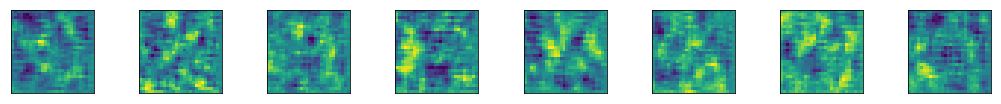

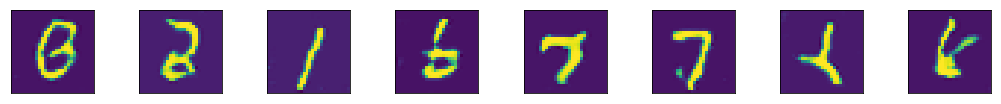

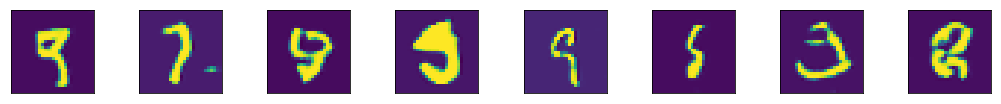

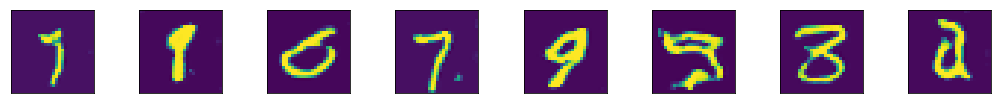

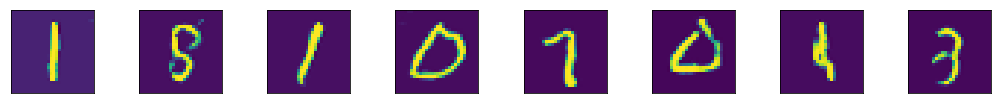

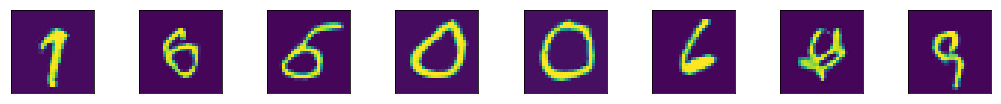

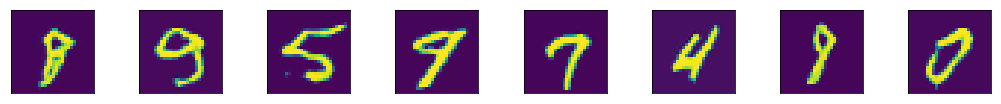

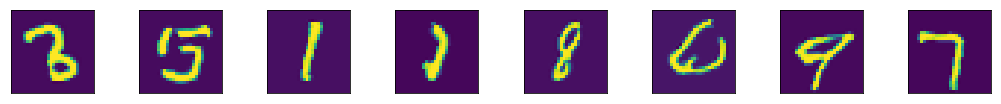

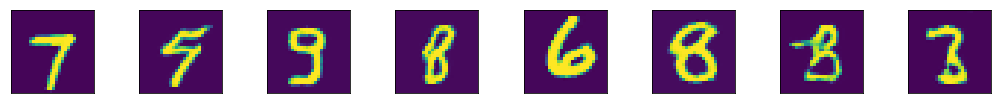

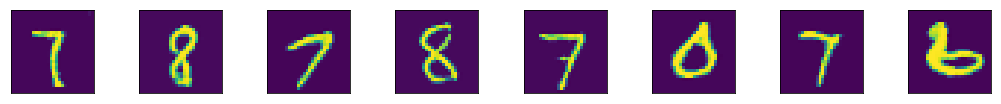

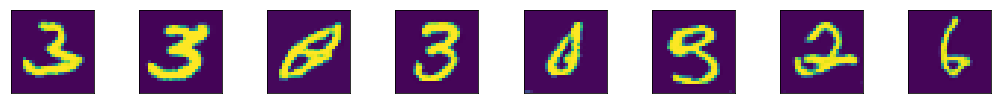

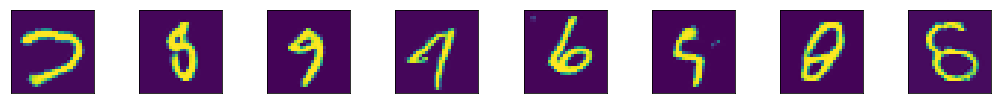

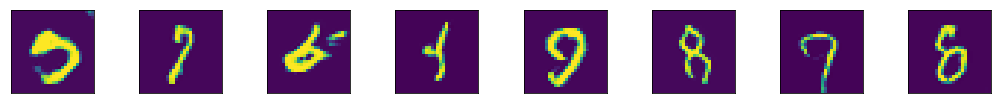

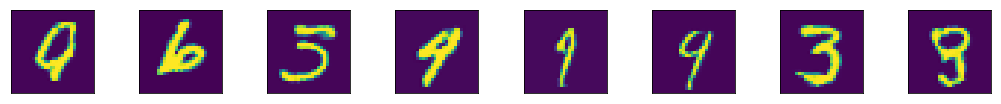

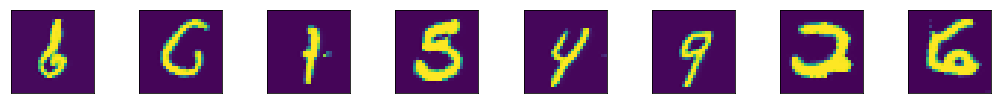

In [22]:
losses = []
for epoca in range(epocas):
    # pegando imagens aleatórias dentro da base de dados
    x_train_true = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    
    # gerando ruído de entrada no gerador - 32 registros com 200 pontos cada
    ruido = np.random.normal(0,1,(batch_size, dimensao_ruido)) 

    # gerar a imagem ruidosa criada a partir do ruido
    x_train_false = gerador.predict(ruido)
    
    # Treinar descriminador para reconhecer imagens verdadeiras
    loss_descriminador_true = descriminador.train_on_batch(x_train_true, y_train_true)

    # Treinar descriminador para reconhecer imagens falsas
    loss_descriminador_false = descriminador.train_on_batch(x_train_false, y_train_false)

    # média dos valores de loss do descriminador
    loss_descriminador = (0.5*np.add(loss_descriminador_true, loss_descriminador_false))

    # treinar a rede como um todo para sair do ruído e tentar obter uma resposta de verdadeiro no final
    loss_model_gan = model_gan.train_on_batch(ruido, y_train_true)

    # Salva os valores de loss do descriminador e do gerador
    losses.append((loss_descriminador[0], loss_model_gan))

    # mostrar imagens geradas a cada 2000 epocas
    if epoca%2000 == 0:
        show_imagens(x_train_false[0:8])

### **Exibindo o gráfico das perdas**

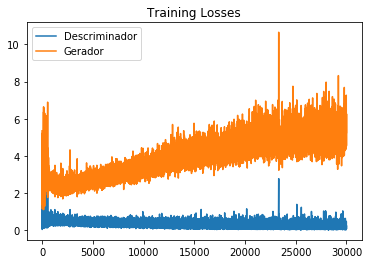

In [23]:
losses = np.array(losses)
fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Descriminador')
plt.plot(losses.T[1], label='Gerador')
plt.title("Training Losses")
plt.legend()
plt.show()